In [20]:
# Importing required libraries

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
from nilearn import plotting 
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Let's keep our notebook clean, so it's a little more readable!

import warnings
warnings.filterwarnings('ignore')

In [22]:
# To view the plots inline with code

%matplotlib inline

# Data Exploration

In [23]:
# Lets fetch the data!

data = datasets.fetch_development_fmri()
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [24]:
# Lets explore data.func


print("Length of data.func", len(data.func))  ## Total Subjects
print("Type of data.func is:", type(data.func))
print("Value stored in data.func[0]",data.func[0]) ## data.func[0] is first element of data.func

# Explore data.phenotypic

print("Type of data.phenotypic is:", type(data.phenotypic))
print("Value stored in data.phenotypic[0]",data.phenotypic[0]) 

# Display Data Description

print("Description of dataset: ", data.description)

# Assign data.phenotypic to a variable; it will be used later for setting labels for classifier

pheno = data.phenotypic

Length of data.func 155
Type of data.func is: <class 'list'>
Value stored in data.func[0] /home/tjays/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Type of data.phenotypic is: <class 'numpy.ndarray'>
Value stored in data.phenotypic[0] ('sub-pixar123', 27.06, 'Adult', 'adult', 'F', 'R')
Description of dataset:  b"The movie watching based brain development dataset (fMRI)\r\n\r\n\r\nNotes\r\n-----\r\nThis functional MRI dataset is used for teaching how to use\r\nmachine learning to predict age from naturalistic stimuli (movie)\r\nwatching with Nilearn.\r\n\r\nThe dataset consists of 50 children (ages 3-13) and 33 young adults (ages\r\n18-39). This dataset can be used to try to predict who are adults and\r\nwho are children.\r\n\r\nThe data is downsampled to 4mm resolution for convenience. The original\r\ndata is downloaded from OpenNeuro.\r\n\r\nFor full information about pre-processing steps on raw-fMRI data, hav

# Brain Parcellation for ROI Specification

In [25]:
# First, let's load a parcellation that we'd like to use

multiscale = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = multiscale.scale064

print('Atlas ROIs are located in nifti image (4D) at: %s' %atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /home/tjays/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


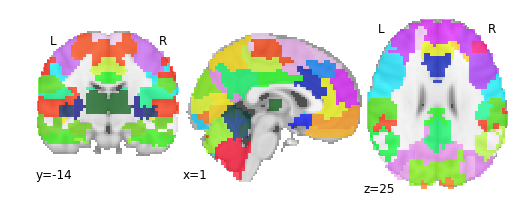

In [26]:
plotting.plot_roi(atlas_filename, draw_cross=False)

# Generating Time-series of Single Subject

In [27]:
# initialize the masker from which we will retrieve a 2D array

masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache', verbose=0)

In [28]:
# example with one participant

sub = data.func[0]
conf = data.confounds[0]

# Extract brain signal while removing confounds

time_series = masker.fit_transform(sub, confounds=conf)

time_series.shape

(168, 64)

# Correlation Matrices

In [29]:
# initialize correlation measure, to build a "connectome"

# set to vectorize (ready for our predictive model later on!)

vectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True, vectorize=True)

# Just to visulalize single subect's correlation matrix

nonvectorized_correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal=True)


In [30]:
nonvectorized_correlation_matrix = nonvectorized_correlation_measure.fit_transform([time_series])[0]
vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
print('Nonvectorized Correlation Matrix.shape: {}'.format(nonvectorized_correlation_matrix.shape))
print('vectorized_correlation_matrix.shape: {}'.format(vectorized_correlation_matrix.shape))

Nonvectorized Correlation Matrix.shape: (64, 64)
vectorized_correlation_matrix.shape: (2016,)


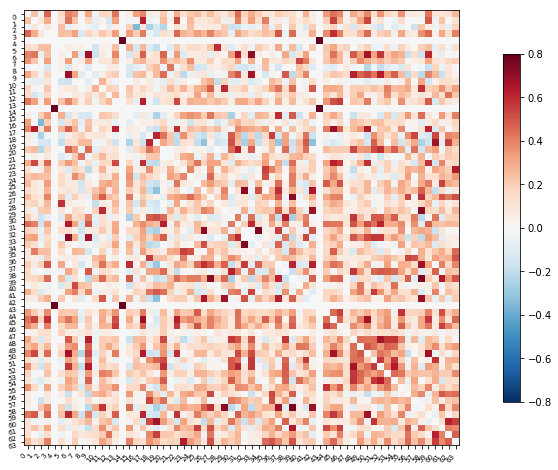

In [31]:
# Mask the main diagonal for visualization:
np.fill_diagonal(nonvectorized_correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label  
plotting.plot_matrix(nonvectorized_correlation_matrix, figure=(10, 8), labels=range(time_series.shape[-1]), vmax=0.8, vmin=-0.8, reorder=False)



# Features Dataframe for Machine Learning 

In [32]:
from tqdm import tqdm

In [ ]:
all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(tqdm(data.func)):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    # create a region x region correlation matrix
    vectorized_correlation_matrix = vectorized_correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(vectorized_correlation_matrix)

In [ ]:
# Let's save the data to disk

np.savez_compressed(os.path.join(os.curdir, 'MAIN_BASC064_subsamp_features'),a = all_features)

In [33]:
# Making features data frame from stored features file

feat_file = os.path.join(os.curdir, 'MAIN_BASC064_subsamp_features.npz')
df_features = pd.DataFrame(np.load(feat_file)['a'])

print(df_features.shape)
df_features.head()

(155, 2016)


,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.377468,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.072512,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.516681,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,-0.070190,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.278559,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354


Text(0,0.5,'subject')

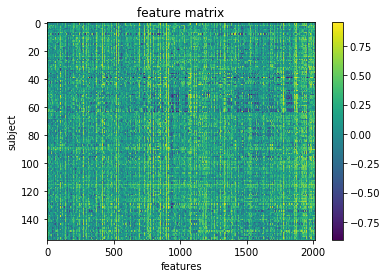

In [34]:
plt.imshow(df_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subject')

In [35]:
df_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,...,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,0.438603,0.115481,0.138229,0.495525,0.325086,0.139913,0.035265,0.049362,0.043459,0.066615,...,0.318569,0.277929,0.157189,0.431242,0.368352,0.484600,0.112711,0.281814,0.249751,0.400408
std,0.136199,0.139860,0.150602,0.138108,0.139446,0.142665,0.129211,0.143999,0.132486,0.152607,...,0.232029,0.212595,0.203954,0.182167,0.186938,0.174347,0.221107,0.221537,0.201770,0.177003
min,-0.040300,-0.259276,-0.386562,0.060856,-0.076095,-0.190003,-0.255162,-0.353081,-0.287570,-0.274818,...,-0.714710,-0.309452,-0.402019,-0.249006,-0.093113,-0.098144,-0.744601,-0.684216,-0.376467,-0.135318
25%,0.363638,0.026928,0.043248,0.417529,0.249166,0.039026,-0.034033,-0.025750,-0.041741,-0.009376,...,0.182286,0.138482,0.015483,0.319277,0.255541,0.386803,-0.010240,0.156909,0.102142,0.305254
50%,0.454781,0.117421,0.134308,0.509799,0.345709,0.148410,0.000082,0.014644,0.011904,0.024636,...,0.361410,0.276618,0.165106,0.465682,0.394346,0.514011,0.132403,0.305244,0.265340,0.424061
75%,0.532945,0.218490,0.245897,0.596292,0.415149,0.233340,0.116784,0.124545,0.113476,0.149484,...,0.468882,0.418125,0.307049,0.564425,0.482785,0.596482,0.269939,0.449185,0.392385,0.523710
max,0.726722,0.536872,0.565612,0.777401,0.607736,0.544285,0.450133,0.465348,0.430848,0.515875,...,0.769479,0.742385,0.659952,0.818867,0.855198,0.814587,0.601870,0.709806,0.783219,0.749233


# Target (Labels) DataFrame for Machine Learning

In [36]:
from sklearn import preprocessing


In [37]:
# Convert pheno to pandas DataFrame

pheno = pd.DataFrame(pheno)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


In [38]:
# Extract Gender Column to another DataFrame df_labels

df_labels = pd.DataFrame(pheno['Gender'])
df_labels

,Gender
0,F
1,M
2,M
3,F
4,F
...,...
150,F
151,F
152,F
153,F


In [39]:
# Convert Categorical Variable "Gender" to numeric 

le = preprocessing.LabelEncoder()
le.fit(df_labels.values)
print(le.classes_)
df_labels = pd.DataFrame(data=le.transform(df_labels.values),columns=['Gender'])
df_labels.head()

['F' 'M']


,Gender
0,0
1,1
2,1
3,0
4,0


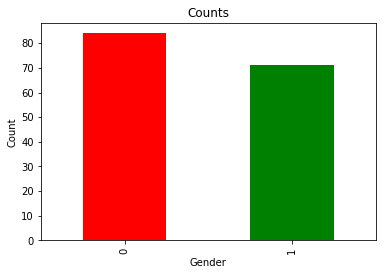

In [56]:
# Plot a Bar Chart depicting the count of each unique value in Gender column

df_labels['Gender'].value_counts().plot(kind='bar',title='Counts', color = ['r', 'g'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [41]:
# Total Count of each unique value of Gender

df_labels['Gender'].value_counts()

0    84
1    71
Name: Gender, dtype: int64

In [42]:
# A combined data frame with all the features and labels columns

df_combined = pd.concat([df_features,df_labels],axis=1, sort=False)
print(df_combined.shape)
print(type(df_combined))
df_combined.head()


(155, 2017)
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Gender
0,0.232860,-0.043625,0.092009,0.465798,0.295241,0.091350,0.000028,-0.000019,0.000017,-0.000013,...,0.135321,0.214588,0.449405,0.231941,0.387250,0.166260,0.551690,0.378682,0.475202,0
1,0.467246,-0.119457,-0.062547,0.472326,0.376036,0.035121,0.000221,0.000038,-0.000191,0.000221,...,0.272233,-0.032882,0.391810,0.232658,0.548074,-0.242473,0.032048,0.095475,0.230578,1
2,0.448596,0.130983,0.316571,0.662571,0.272684,0.098411,-0.023168,-0.069897,0.066056,0.024636,...,0.628576,0.405334,0.591906,0.656595,0.554171,0.376697,0.512734,0.457288,0.640499,1
3,0.236547,0.048036,0.002236,0.448658,0.142590,0.068359,-0.053419,-0.029784,0.014794,0.036110,...,0.530982,0.072605,0.175955,0.194926,0.170638,0.191752,0.135061,0.135847,0.368537,0
4,0.244007,0.083132,0.342197,0.341674,-0.076095,-0.086215,0.135303,-0.107674,-0.012754,0.168019,...,0.092597,0.269093,0.413449,0.128707,0.338674,0.145776,0.345804,0.177099,0.419354,0


In [43]:
df_combined.Gender.unique()

array([0, 1])

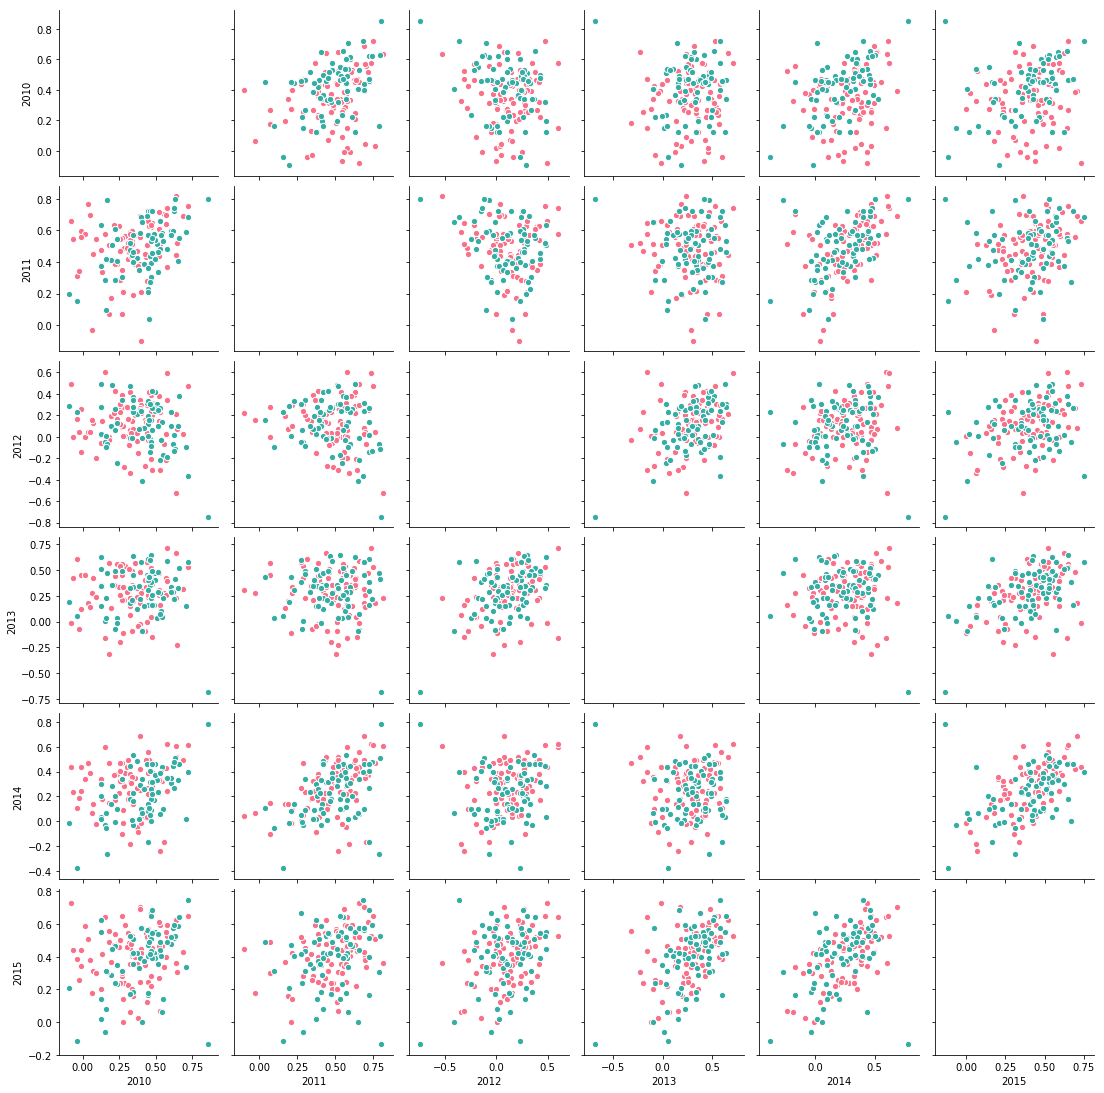

In [44]:
# Grid Plot or matrix plot

g = sns.PairGrid(df_combined.iloc[:,2010:2017], hue="Gender", palette = 'husl')
#g = g.map_diag(plt.hist, edgecolor = "w") # histogram on diagonals
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40) #off diagonals will be scatter plots; s=40 telling the size of grid
plt.show()

# Train/Test Set for ML

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# Split the sample to training/validation with a 70/30 ratio, and 
# stratify by df_labels, and also shuffle the data.

def train_val_sets (df_features, df_labels):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    df_features, # x
                                                    df_labels.values, # y
                                                    test_size = 0.30, # 70%/30% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = df_labels.values,  # keep
                                                                           # distribution
                                                                           # of Gender
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    # print the size of our training and test groups

    print('training:', len(X_train), 'testing:', len(X_val))
    return X_train, X_val, y_train, y_val

training: 108 testing: 47


In [ ]:
X_train, X_val, y_train, y_val = train_val_sets(df_features, df_labels)

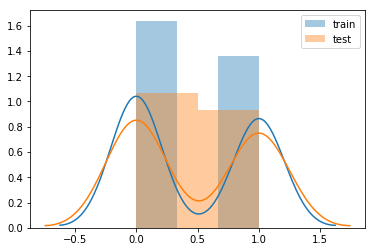

In [47]:
# Plotting distribution of y_train and y_test samples

sns.distplot(y_train,label='train')
sns.distplot(y_val,label='val')
plt.legend()

# Classification Models

In [62]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [63]:
# Names of Classifiers

clf_names = ['Logistic Regression', 
             'K-Nearest Neighbors', 
             'Multilayer Perceptron', 
             'Gaussian Naive Bayes', 
             'Decision Tree', 
             'Random Forest']

In [97]:
# Classifiers Initiation

classifiers = [LogisticRegression(random_state = 0),
               KNeighborsClassifier(n_neighbors = 3),
               MLPClassifier(hidden_layer_sizes=(20,20,20), random_state=1),
               GaussianNB(),
               DecisionTreeClassifier(max_depth = 3),
               RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1)]

In [65]:
# Function Definition for Confusion Matrix

def conf_matrix(test_Y, prediction):
    con_matrix = confusion_matrix(test_Y,prediction)
    print('Confusion_matrix', con_matrix)
    plt.figure()
    plt.matshow(con_matrix,cmap='Pastel1')
    for x in range(0, 2):
        for y in range(0,2):
            plt.text(x,y,con_matrix[x, y])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print('True Negative = ',con_matrix[0][0])
    print('False Negative = ',con_matrix[0][1])
    print('False Positive = ',con_matrix[1][0])
    print('True Positive = ',con_matrix[1][1])
    

Logistic Regression


Accuracy of Logistic Regression: 0.6054545454545455
Area Under Curve of Logistic Regression: 0.6341666666666665
f1 score of Logistic Regression: 0.5487734487734488
Confusion_matrix [[38 21]
 [22 27]]


<Figure size 432x288 with 0 Axes>

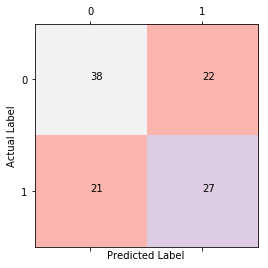

True Negative =  38
False Negative =  21
False Positive =  22
True Positive =  27


K-Nearest Neighbors


Accuracy of K-Nearest Neighbors: 0.5018181818181818
Area Under Curve of K-Nearest Neighbors: 0.4855833333333333
f1 score of K-Nearest Neighbors: 0.4467310467310467
Confusion_matrix [[33 26]
 [28 21]]


<Figure size 432x288 with 0 Axes>

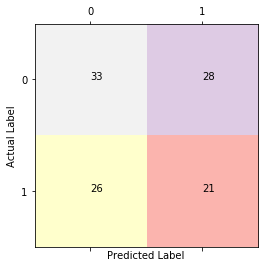

True Negative =  33
False Negative =  26
False Positive =  28
True Positive =  21


Multilayer Perceptron


Accuracy of Multilayer Perceptron: 0.5681818181818181
Area Under Curve of Multilayer Perceptron: 0.6193333333333333
f1 score of Multilayer Perceptron: 0.5308025308025308
Confusion_matrix [[34 25]
 [22 27]]


<Figure size 432x288 with 0 Axes>

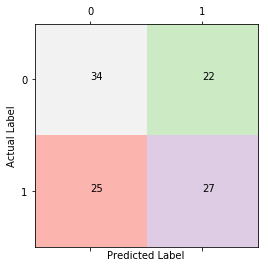

True Negative =  34
False Negative =  25
False Positive =  22
True Positive =  27


Gaussian Naive Bayes


Accuracy of Gaussian Naive Bayes: 0.6027272727272727
Area Under Curve of Gaussian Naive Bayes: 0.5998333333333333
f1 score of Gaussian Naive Bayes: 0.5498556998556998
Confusion_matrix [[37 22]
 [21 28]]


<Figure size 432x288 with 0 Axes>

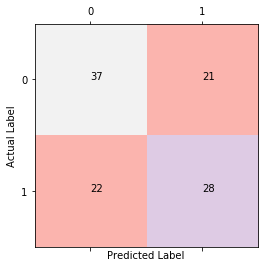

True Negative =  37
False Negative =  22
False Positive =  21
True Positive =  28


Decision Tree


Accuracy of Decision Tree: 0.5390909090909091
Area Under Curve of Decision Tree: 0.5816666666666668
f1 score of Decision Tree: 0.54004329004329
Confusion_matrix [[33 26]
 [18 31]]


<Figure size 432x288 with 0 Axes>

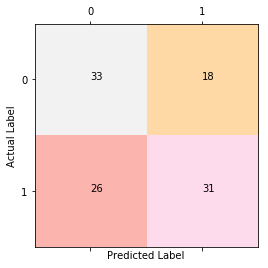

True Negative =  33
False Negative =  26
False Positive =  18
True Positive =  31


Random Forest


Accuracy of Random Forest: 0.4354545454545454
Area Under Curve of Random Forest: 0.41583333333333333
f1 score of Random Forest: 0.5093362193362193
Confusion_matrix [[44 15]
 [34 15]]


<Figure size 432x288 with 0 Axes>

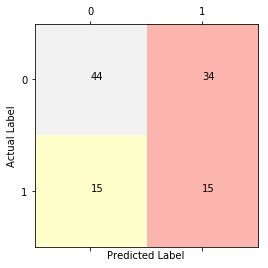

True Negative =  44
False Negative =  15
False Positive =  34
True Positive =  15




In [98]:
def ML_metrics (X_train, y_train):
    
    for name, clf in zip(clf_names, classifiers):
    
        print("{}\n\n".format(name))

        # predict
        y_pred = cross_val_predict(clf, X_train, y_train, cv=10)

        # scores
        acc = cross_val_score(clf, X_train, y_train, cv=10).mean()
        roc_auc = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'roc_auc').mean()
        f1 = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'f1').mean()

        print("Accuracy of {}: {}".format(name,acc))
        print("Area Under Curve of {}: {}".format(name,roc_auc))
        print("f1 score of {}: {}".format(name, f1))

        conf_matrix(y_train,y_pred)

        print("==================================================================================================================\n\n")
        
        return  y_pred, acc, roc_auc, f1

In [ ]:
y_pred, acc, roc_auc, f1 = ML_metrics(X_train, y_train)

# Dimensionality Reduction

## PCA

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA(.95)
x_pca = pca.fit_transform(df_features)
print(x_pca.shape)

(155, 110)


In [59]:
print(x_pca)

[[ 4.99467805e-01 -1.93200675e+00 -6.38695113e-01 ... -3.08831544e-01
  -2.51094703e-01 -5.91645588e-01]
 [-2.65650810e+00  5.87487382e-01 -5.94614479e-01 ... -8.18518435e-01
  -2.06139128e-02 -4.13296031e-02]
 [ 5.61607128e+00  7.97907169e-01 -9.19494997e-02 ... -3.34854303e-01
  -4.09376517e-01 -4.11415974e-03]
 ...
 [-1.64564078e+00 -1.35413191e+00 -7.17856274e-01 ...  2.61808614e-02
   4.61951139e-02  3.10417997e-01]
 [-1.16265783e+00  2.80903176e+00  2.89982213e-01 ... -4.57465629e-02
   1.20555690e-01  1.53918162e-01]
 [-7.24587247e-02 -8.72705091e-01 -2.97854460e+00 ...  3.38065715e-01
  -5.99701251e-01  1.25647995e-01]]


Text(0,0.5,'Second Principal Component')

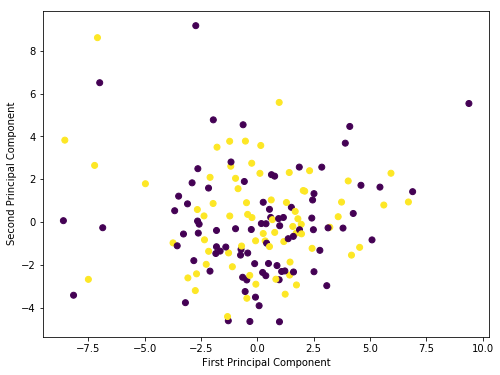

In [60]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c = df_labels['Gender'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_val_sets()